In [ ]:
!git clone https://github.com/facebookresearch/sam3.git

fatal: destination path 'sam3' already exists and is not an empty directory.


In [ ]:
%cd /content/sam3
!pwd

/content/sam3
/content/sam3


following command may ask you to restart your runtime. That's fine. Do that and then run the above cd cell adn the `pip install -e .` below again. You'll be good to go

In [ ]:
!pip install -e .

Obtaining file:///content/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for sam3 (pyproject.toml) ... done
  Created wheel for sam3: filename=sam3-0.1.0-0.editable-py3-none-any.whl size=15197 sha256=6916eca2a826ac0fe4919afd4ad46473c340dfbc91d66555f30a19de0d21b8f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ymhe1we/wheels/7c/90/be/80339bb9db8655024d6c9501da4e5efc6abbda4c897f5a6c43
Successfully built sam3
  Attempting uninstall: sam3
    Found existing installation: sam3 0.1.0
    Uninstalling sam3-0.1.0:
      Successfully uninstalled sam3-0.1.0


In [ ]:
!pwd

/content/sam3


In [ ]:
!pip install -e ".[notebooks]"

Obtaining file:///content/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for sam3 (pyproject.toml) ... done
  Created wheel for sam3: filename=sam3-0.1.0-0.editable-py3-none-any.whl size=15197 sha256=bd85947ec6451cabcd76570092b4211f62e5e19b24ac2d80d2e22ff78fe38627
  Stored in directory: /tmp/pip-ephem-wheel-cache-99qghk_p/wheels/7c/90/be/80339bb9db8655024d6c9501da4e5efc6abbda4c897f5a6c43
Successfully built sam3
  Attempting uninstall: sam3
    Found existing installation: sam3 0.1.0
    Uninstalling sam3-0.1.0:
      Successfully uninstalled sam3-0.1.0


## HF Login
Must be done for access to model card: https://huggingface.co/docs/hub/en/security-tokens

In [ ]:
from huggingface_hub import login
login()

### Build Model

In [ ]:
%cd /content/sam3
!pwd # MUST be /content/sam3

/content/sam3
/content/sam3


In [ ]:
import torch
from PIL import Image
from sam3.model_builder import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model
model = build_sam3_image_model().to(device)
processor = Sam3Processor(model)

## Inference

In [ ]:
!pwd

/content/sam3


In [ ]:
!pip install -U transformers

In [ ]:
from PIL import Image
from sam3.model_builder import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor
import requests
# Load the model
model = build_sam3_image_model()
processor = Sam3Processor(model)

In [ ]:
# Load an image
image_url = "http://images.cocodataset.org/val2017/000000077595.jpg"
image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")

In [ ]:
inference_state = processor.set_image(image)
# Prompt the model with text
output = processor.set_text_prompt(state=inference_state, prompt="segment the cat")

In [ ]:
# Get the masks, bounding boxes, and scores
masks, boxes, scores = output["masks"], output["boxes"], output["scores"]

In [1]:
from PIL import Image
import numpy as np
import matplotlib
import torch

def overlay_masks(image: Image.Image, masks: torch.Tensor) -> Image.Image:
    """
    image: PIL.Image (RGB or RGBA)
    masks: torch.Tensor from SAM3, can be:
           - [num_masks, H, W]
           - [batch, num_masks, H, W]
           - [1, H, W] / [1, 1, H, W]
    """
    image = image.convert("RGBA")

    # Move to CPU + numpy
    if isinstance(masks, torch.Tensor):
        masks_np = masks.detach().cpu().numpy()
    else:
        masks_np = np.array(masks)

    # Normalize shape so we end up with [N, H, W]
    if masks_np.ndim == 4:
        # Assume [batch, num_masks, H, W]
        b, n, h, w = masks_np.shape
        masks_np = masks_np.reshape(b * n, h, w)  # -> [N, H, W]
    elif masks_np.ndim == 3:
        # Either [N, H, W] or [1, H, W]; both are fine
        pass
    elif masks_np.ndim == 2:
        # Single mask [H, W]
        masks_np = masks_np[None, ...]  # -> [1, H, W]
    else:
        raise ValueError(f"Unexpected mask shape: {masks_np.shape}")

    # Binarize / scale to [0, 255]
    masks_np = (masks_np > 0).astype(np.uint8) * 255

    n_masks = masks_np.shape[0]
    if n_masks == 0:
        return image

    cmap = matplotlib.colormaps.get_cmap("rainbow").resampled(n_masks)
    colors = [
        tuple(int(c * 255) for c in cmap(i)[:3])
        for i in range(n_masks)
    ]

    for mask_arr, color in zip(masks_np, colors):
        # mask_arr is [H, W] now
        mask_pil = Image.fromarray(mask_arr, mode="L")

        # Resize mask if needed to match image size
        if mask_pil.size != image.size:
            mask_pil = mask_pil.resize(image.size, resample=Image.NEAREST)

        overlay = Image.new("RGBA", image.size, color + (0,))
        alpha = mask_pil.point(lambda v: int(v * 0.5))  # 0.5 = 50% opacity
        overlay.putalpha(alpha)
        image = Image.alpha_composite(image, overlay)

    return image

In [ ]:
# simple score threshold
score_threshold = 0.5
keep = scores > score_threshold

filtered_masks = masks[keep]
filtered_boxes = boxes[keep]
filtered_scores = scores[keep]

# render overlay
# vis_image = overlay_masks(image, filtered_masks)
# vis_image.save("sam3_people_overlay.png")
vis = overlay_masks(image, masks)   # use output["masks"] directly
vis.save("sam3_overlay.png")        # or display in notebook

/tmp/ipython-input-680800499.py:51: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask_arr, mode="L")


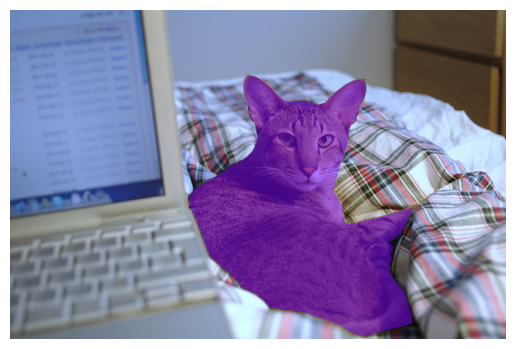

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(vis)
plt.axis("off")
plt.show()

### Let's try a more complicated cityscape with multiple objects of relevance - people walking!

In [ ]:
image_url = "https://thumbs.dreamstime.com/b/bustling-city-view-busy-nyc-times-square-far-background-85173323.jpg"
image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")

inference_state = processor.set_image(image)
# Prompt the model with text
output = processor.set_text_prompt(state=inference_state, prompt="Any people walking")

# Get the masks, bounding boxes, and scores
masks, boxes, scores = output["masks"], output["boxes"], output["scores"]

/tmp/ipython-input-680800499.py:51: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask_arr, mode="L")


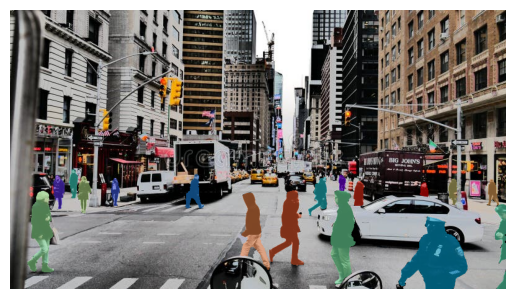

In [ ]:
vis_city = overlay_masks(image, masks)   # use output["masks"] directly
vis_city.save("sam3_city_example.png")

plt.imshow(vis_city)
plt.axis("off")
plt.show()

/tmp/ipython-input-680800499.py:51: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask_arr, mode="L")


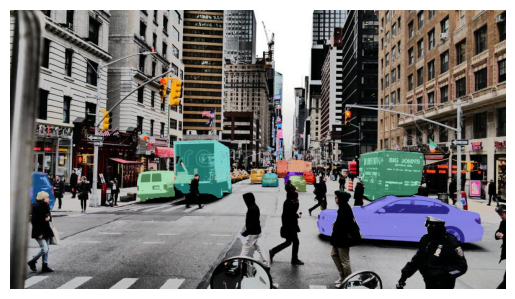

In [ ]:
image_url = "https://thumbs.dreamstime.com/b/bustling-city-view-busy-nyc-times-square-far-background-85173323.jpg"
image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")

inference_state = processor.set_image(image)
# Prompt the model with text
output = processor.set_text_prompt(state=inference_state, prompt="all vehicles")

# Get the masks, bounding boxes, and scores
masks, boxes, scores = output["masks"], output["boxes"], output["scores"]

vis_city_all = overlay_masks(image, masks)   # use output["masks"] directly
vis_city_all.save("sam3_city_all_example.png")

plt.imshow(vis_city_all)
plt.axis("off")
plt.show()

# Benchmarking

In [14]:
!pip install cityscapesscripts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.6/473.6 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.4 MB/s eta 0:00:00
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26304 sha256=a1aa41fb4237f3c0516856a032a0a523f2ccb2c6e248d59c50cb6bb64a954249
  Stored in directory: /root/.cache/pip/wheels/12/98/52/2bffe242a9a487f00886e43b8ed8dac46456702e11a0d6abef
Successfully built typing


In [ ]:
# --- Step 1: SAM3 + Cityscapes label schema and per-image prediction ---

from dataclasses import dataclass
from typing import Dict, List
from collections import defaultdict

import numpy as np
from PIL import Image
import torch

# Cityscapes label definitions (gives id, trainId, category, etc.)
# pip install cityscapesscripts if you don't have it yet
from cityscapesscripts.helpers.labels import labels as CS_LABELS

# SAM3: Meta repo API (what you're already using)
from sam3.model_builder import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor


# -------- Label configuration (generic pattern for any dataset) --------

@dataclass
class LabelSpec:
    name: str            # "road"
    group: str           # "flat"
    prompt: str          # text prompt for SAM3, e.g. "road surface"
    id: int              # Cityscapes labelId
    train_id: int        # Cityscapes trainId (0-18, 255 = ignore)
    has_instances: bool  # True for "thing" classes
    ignore_in_eval: bool # True for '+' labels / void classes


def build_cityscapes_label_specs() -> Dict[str, LabelSpec]:
    """
    Build LabelSpec objects directly from Cityscapes metadata.

    This is the only dataset-specific part; for a different dataset,
    implement an analogous builder that returns {name -> LabelSpec}.
    """
    specs: Dict[str, LabelSpec] = {}
    for lab in CS_LABELS:
        specs[lab.name] = LabelSpec(
            name=lab.name,
            group=lab.category,                         # flat, human, vehicle, ...
            prompt=lab.name.replace("_", " "),          # default prompt
            id=lab.id,
            train_id=lab.trainId,
            has_instances=lab.hasInstances,
            ignore_in_eval=lab.ignoreInEval,
        )
    return specs


CITYSCAPES_LABEL_SPECS: Dict[str, LabelSpec] = build_cityscapes_label_specs()

# Group -> list of class names (for inspection / grouping)
CITYSCAPES_GROUPS: Dict[str, List[str]] = defaultdict(list)
for spec in CITYSCAPES_LABEL_SPECS.values():
    CITYSCAPES_GROUPS[spec.group].append(spec.name)

# Map raw labelId -> trainId (255 for ignore)
CITYSCAPES_ID2TRAINID: Dict[int, int] = {}
for spec in CITYSCAPES_LABEL_SPECS.values():
    tid = spec.train_id
    if tid < 0:
        tid = 255
    CITYSCAPES_ID2TRAINID[spec.id] = tid

# Official 19 evaluation classes: trainId >= 0 and not ignoreInEval
CITYSCAPES_EVAL_TRAIN_IDS: List[int] = sorted(
    {
        spec.train_id
        for spec in CITYSCAPES_LABEL_SPECS.values()
        if spec.train_id >= 0 and not spec.ignore_in_eval
    }
)

CITYSCAPES_TRAINID2NAME: Dict[int, str] = {
    spec.train_id: spec.name
    for spec in CITYSCAPES_LABEL_SPECS.values()
    if spec.train_id in CITYSCAPES_EVAL_TRAIN_IDS
}

# We keep 0..255 as possible trainIds (255 = void)
CITYSCAPES_NUM_CLASSES: int = 256
CITYSCAPES_IGNORE_INDEX: int = 255


# -------- SAM3 model + generic cityscapes prediction function --------

device = "cuda" if torch.cuda.is_available() else "cpu"
model = build_sam3_image_model().to(device)
processor = Sam3Processor(model)
model.eval()


def sam3_predict_cityscapes_trainids(
    image: Image.Image,
    score_threshold: float = 0.5,
) -> np.ndarray:
    """
    Segment an image with SAM3 using *all* Cityscapes classes.

    Returns:
        pred_trainids: (H, W) uint8 array of Cityscapes trainIds
                       (0-18 for eval classes, 255 = void/ignore)

    This is dataset-specific only through CITYSCAPES_LABEL_SPECS;
    for another dataset you can plug in a different LabelSpec dict.
    """
    w, h = image.size
    # SAM3 caches vision features inside this state object
    inference_state = processor.set_image(image)

    # For each pixel: best class score so far & its trainId
    best_score = np.full((h, w), -1e9, dtype=np.float32)
    pred_trainids = np.full((h, w), CITYSCAPES_IGNORE_INDEX, dtype=np.uint8)

    for spec in CITYSCAPES_LABEL_SPECS.values():
        # Optionally skip truly void labels for prediction
        if spec.name in ["ground", "dynamic", "static"]:
            # They belong to the "void" group and are ignored in eval;
            # skip here to focus on more meaningful classes.
            continue

        # Text prompt for this class (you can hand-tune these later)
        prompt = spec.prompt

        out = processor.set_text_prompt(state=inference_state, prompt=prompt)
        masks = out["masks"]      # [N, H, W] or [N, 1, H, W]
        scores = out["scores"]    # [N]

        if masks is None or masks.numel() == 0:
            continue

        keep = scores > score_threshold
        if keep.sum() == 0:
            continue

        masks = masks[keep]
        scores = scores[keep]

        # Convert to numpy [N, H, W] boolean masks
        if masks.ndim == 4:
            masks_np = masks.squeeze(1).detach().cpu().numpy().astype(bool)
        else:
            masks_np = masks.detach().cpu().numpy().astype(bool)
        scores_np = scores.detach().cpu().numpy().astype(np.float32)

        # For each instance, update pixels where it wins on score
        for m, s in zip(masks_np, scores_np):
            if s <= 0:  # optional extra filter
                continue

            update = m & (s > best_score)
            if not np.any(update):
                continue

            # Use trainId if available, otherwise treat as void
            tid = spec.train_id if spec.train_id >= 0 else CITYSCAPES_IGNORE_INDEX
            pred_trainids[update] = np.uint8(tid)
            best_score[update] = s

    return pred_trainids

In [1]:
# If your dataset is on Drive, mount and point ROOT there
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from pathlib import Path
CITYSCAPES_ROOT = Path("/content/drive/MyDrive/UCLA/Datasets/cityscapes")
# CITYSCAPES_ROOT = Path("/content/drive/MyDrive/cityscapes")

In [3]:
# --- Step 2: Load Cityscapes val split paths in Colab ---

def list_cityscapes_split(root: Path, split: str = "val"):
    img_dir = root / "leftImg8bit_trainvaltest" / "leftImg8bit" / split
    gt_dir  = root / "gtFine_trainvaltest" / "gtFine" / split

    image_paths = sorted(img_dir.rglob("*_leftImg8bit.png"))
    print(f"Found {len(image_paths)} images in split='{split}'")
    return image_paths, gt_dir

val_image_paths, val_gt_dir = list_cityscapes_split(CITYSCAPES_ROOT, split="val")


Found 500 images in split='val'


In [4]:
# --- Step 3: Build a parseable representation (DataFrame) for val ---

import pandas as pd

def make_cityscapes_dataframe(root: Path, split: str = "val") -> pd.DataFrame:
    img_dir = root / "leftImg8bit_trainvaltest" / "leftImg8bit" / split
    gt_dir  = root / "gtFine_trainvaltest" / "gtFine" / split

    records = []
    for img_path in sorted(img_dir.rglob("*_leftImg8bit.png")):
        city = img_path.parent.name
        stem = img_path.name.replace("_leftImg8bit.png", "")

        label_ids = gt_dir / city / f"{stem}_gtFine_labelIds.png"
        instance_ids = gt_dir / city / f"{stem}_gtFine_instanceIds.png"
        color_png = gt_dir / city / f"{stem}_gtFine_color.png"
        polygons_json = gt_dir / city / f"{stem}_gtFine_polygons.json"

        records.append(
            {
                "city": city,
                "image_id": stem,
                "image_path": str(img_path),
                "labelIds_path": str(label_ids),
                "instanceIds_path": str(instance_ids),
                "color_path": str(color_png),
                "polygons_path": str(polygons_json),
            }
        )

    df = pd.DataFrame.from_records(records)
    return df


val_df = make_cityscapes_dataframe(CITYSCAPES_ROOT, split="val")
print("Total val samples:", len(val_df))
display(val_df.head())


Total val samples: 500


,city,image_id,image_path,labelIds_path,instanceIds_path,color_path,polygons_path
0,frankfurt,frankfurt_000000_000294,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
1,frankfurt,frankfurt_000000_000576,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
2,frankfurt,frankfurt_000000_001016,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
3,frankfurt,frankfurt_000000_001236,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
4,frankfurt,frankfurt_000000_001751,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...


In [5]:
# --- Step 4: Run SAM3 inference over every row in the DataFrame ---

from tqdm.auto import tqdm
import numpy as np

PRED_ROOT = CITYSCAPES_ROOT / "sam3_preds" / "val"
PRED_ROOT.mkdir(parents=True, exist_ok=True)


def run_sam3_inference_over_df(
    df: pd.DataFrame,
    pred_root: Path,
    overwrite: bool = False,
    score_threshold: float = 0.5,
) -> pd.DataFrame:
    """
    Generic pattern:
      - iterate df rows
      - load image
      - call a `predict(image)` function (here: sam3_predict_cityscapes_trainids)
      - save predictions to disk
      - store prediction path back into df

    For another dataset, keep this exactly the same and just swap the predict fn.
    """
    df = df.copy()
    pred_paths = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = Path(row["image_path"])
        image_id = row["image_id"]

        out_path = pred_root / f"{image_id}_sam3_trainIds.npy"
        if out_path.exists() and not overwrite:
            pred_paths.append(str(out_path))
            continue

        img = Image.open(img_path).convert("RGB")
        pred_trainids = sam3_predict_cityscapes_trainids(
            img, score_threshold=score_threshold
        )

        np.save(out_path, pred_trainids)
        pred_paths.append(str(out_path))

    df["pred_trainIds_path"] = pred_paths
    return df


val_df_pred = run_sam3_inference_over_df(
    val_df,
    pred_root=PRED_ROOT,
    overwrite=False,
    score_threshold=0.5,
)

display(val_df_pred.head())


  0%|          | 0/500 [00:00<?, ?it/s]

,city,image_id,image_path,labelIds_path,instanceIds_path,color_path,polygons_path,pred_trainIds_path
0,frankfurt,frankfurt_000000_000294,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
1,frankfurt,frankfurt_000000_000576,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
2,frankfurt,frankfurt_000000_001016,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
3,frankfurt,frankfurt_000000_001236,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
4,frankfurt,frankfurt_000000_001751,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...


In [11]:
# --- Step 5: Evaluate SAM3 predictions (semantic mIoU) ---
from PIL import Image
import numpy as np

def labelIds_to_trainIds(label_ids: np.ndarray) -> np.ndarray:
    """
    Map Cityscapes labelIds to trainIds using CITYSCAPES_ID2TRAINID.
    255 is used as ignore index.
    """
    train = np.full_like(label_ids, CITYSCAPES_IGNORE_INDEX, dtype=np.uint8)
    for raw_id, tid in CITYSCAPES_ID2TRAINID.items():
        train[label_ids == raw_id] = np.uint8(tid)
    return train


def confusion_matrix_from_df(
    df: pd.DataFrame,
    num_classes: int = CITYSCAPES_NUM_CLASSES,
    ignore_index: int = CITYSCAPES_IGNORE_INDEX,
) -> np.ndarray:
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    for _, row in df.iterrows():
        gt = np.array(Image.open(row["labelIds_path"]), dtype=np.int32)
        gt_train = labelIds_to_trainIds(gt)

        pred_train = np.load(row["pred_trainIds_path"]).astype(np.int32)
        assert gt_train.shape == pred_train.shape, "GT/pred shape mismatch"

        # Ignore pixels where GT is void
        mask = gt_train != ignore_index
        gt_flat = gt_train[mask].astype(np.int64) # Cast to int64
        pred_flat = pred_train[mask].astype(np.int64) # Cast to int64

        # Clamp predictions to valid range [0, num_classes-1]
        pred_flat = np.clip(pred_flat, 0, num_classes - 1)

        cm += np.bincount(
            num_classes * gt_flat + pred_flat,
            minlength=num_classes ** 2,
        ).reshape(num_classes, num_classes)

    return cm


def iou_from_confusion(cm: np.ndarray) -> np.ndarray:
    intersection = np.diag(cm)
    union = cm.sum(1) + cm.sum(0) - intersection
    iou = intersection / np.maximum(union, 1)
    return iou


cm = confusion_matrix_from_df(val_df_pred)
ious = iou_from_confusion(cm)

print("Per-class IoU (Cityscapes 19 eval classes):")
for tid in CITYSCAPES_EVAL_TRAIN_IDS:
    name = CITYSCAPES_TRAINID2NAME[tid]
    print(f"{tid:2d} {name:>12s}: {ious[tid] * 100:5.2f}%")

miou = np.mean([ious[tid] for tid in CITYSCAPES_EVAL_TRAIN_IDS])
print(f"\nMean IoU over {len(CITYSCAPES_EVAL_TRAIN_IDS)} classes: {miou * 100:5.2f}%")

KeyboardInterrupt: 

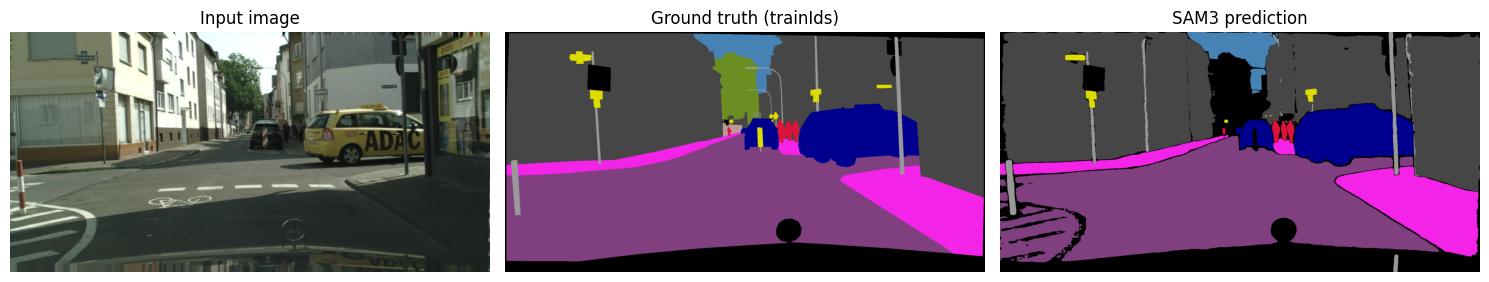

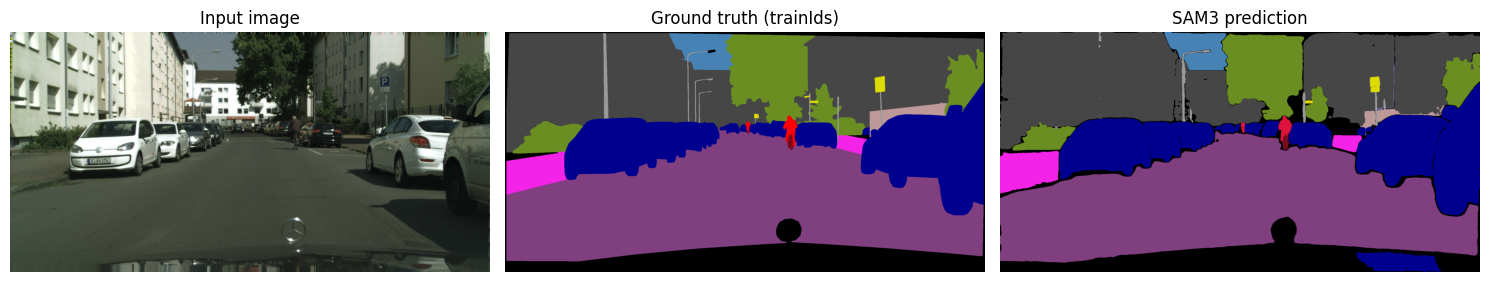

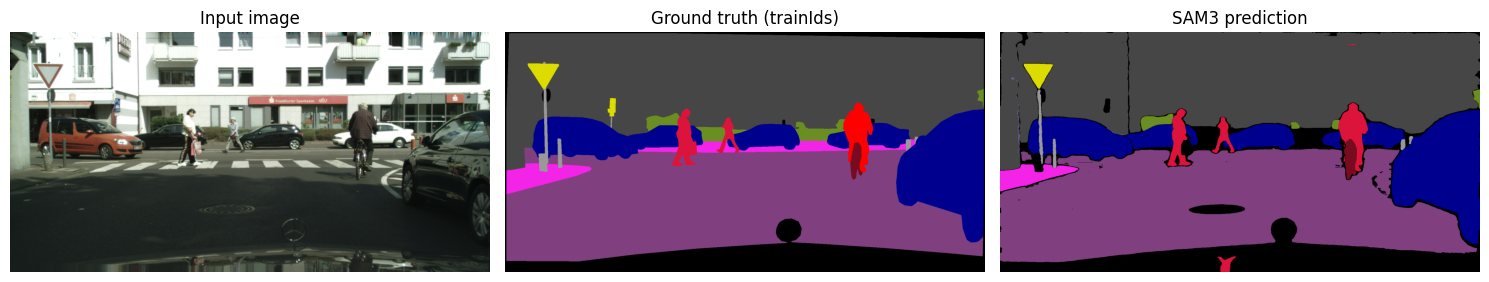

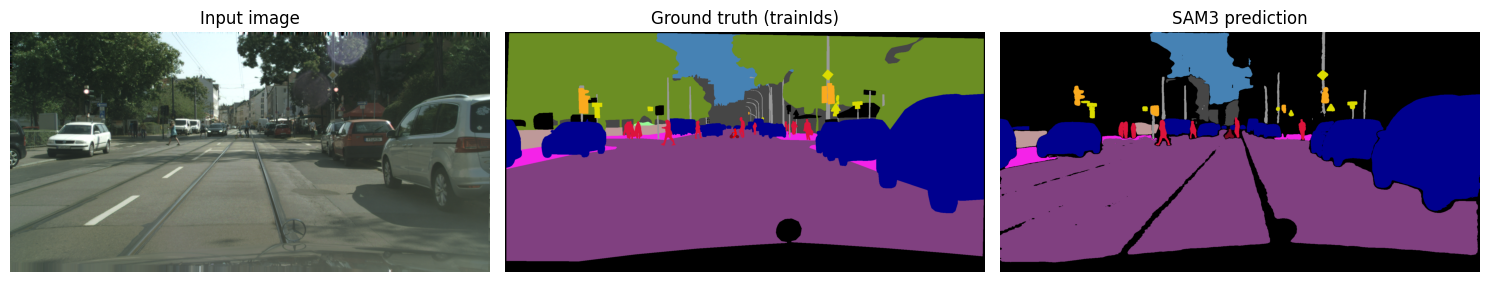

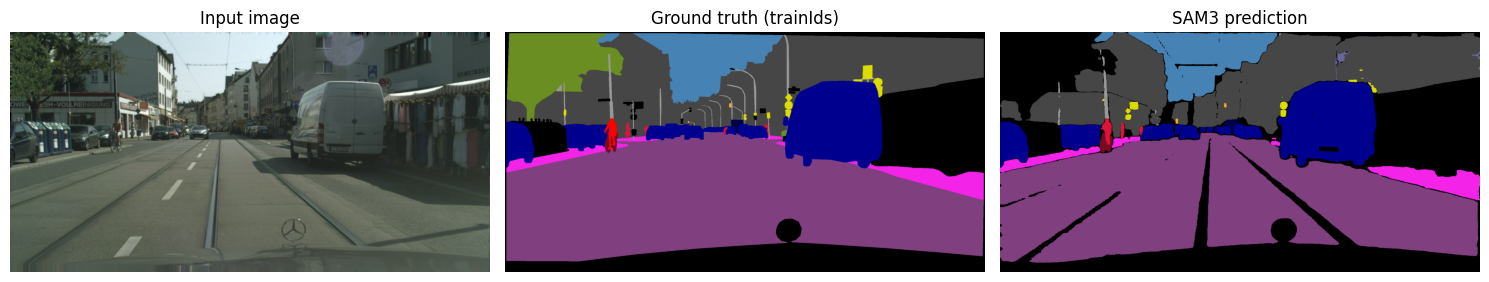

In [ ]:
# --- Visualize first few SAM3 inference results (image | GT | prediction) ---

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from cityscapesscripts.helpers import labels as cs_labels  # already imported as CS_LABELS earlier

# Build a color palette for trainIds using official Cityscapes colors
TRAINID2COLOR = {}
for lab in cs_labels.labels:
    if lab.trainId < 0 or lab.trainId == 255:  # ignore / void
        continue
    TRAINID2COLOR[lab.trainId] = lab.color  # (R, G, B)

def colorize_trainids(trainids: np.ndarray) -> Image.Image:
    """Map trainId mask (H,W) -> RGB PIL.Image using Cityscapes colors."""
    h, w = trainids.shape
    color = np.zeros((h, w, 3), dtype=np.uint8)
    for tid, rgb in TRAINID2COLOR.items():
        mask = (trainids == tid)
        color[mask] = rgb
    return Image.fromarray(color)


N_SHOW = 5  # how many examples to visualize
for _, row in val_df_pred.head(N_SHOW).iterrows():
    # Load image
    img = Image.open(row["image_path"]).convert("RGB")

    # Ground-truth: labelIds -> trainIds
    gt_labelids = np.array(Image.open(row["labelIds_path"]), dtype=np.int32)
    gt_trainids = labelIds_to_trainIds(gt_labelids)

    # Prediction: saved trainId mask
    pred_trainids = np.load(row["pred_trainIds_path"]).astype(np.uint8)

    # Colorized visualizations
    gt_color = colorize_trainids(gt_trainids)
    pred_color = colorize_trainids(pred_trainids)

    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title("Input image")
    axes[0].axis("off")

    axes[1].imshow(gt_color)
    axes[1].set_title("Ground truth (trainIds)")
    axes[1].axis("off")

    axes[2].imshow(pred_color)
    axes[2].set_title("SAM3 prediction")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


In [7]:
from dataclasses import dataclass
from typing import Dict, List
from collections import defaultdict

from cityscapesscripts.helpers.labels import labels as CS_LABELS


@dataclass
class LabelSpec:
    name: str            # "road"
    group: str           # "flat"
    prompt: str          # text prompt for SAM3, e.g. "road surface"
    id: int              # Cityscapes labelId
    train_id: int        # Cityscapes trainId (0-18, 255 = ignore)
    has_instances: bool  # True for "thing" classes
    ignore_in_eval: bool # True for '+' labels / void classes


def build_cityscapes_label_specs() -> Dict[str, LabelSpec]:
    """
    Build LabelSpec objects directly from Cityscapes metadata.

    This is the only dataset-specific part; for a different dataset,
    implement an analogous builder that returns {name -> LabelSpec}.
    """
    specs: Dict[str, LabelSpec] = {}
    for lab in CS_LABELS:
        specs[lab.name] = LabelSpec(
            name=lab.name,
            group=lab.category,                         # flat, human, vehicle, ...
            prompt=lab.name.replace("_", " "),          # default prompt
            id=lab.id,
            train_id=lab.trainId,
            has_instances=lab.hasInstances,
            ignore_in_eval=lab.ignoreInEval,
        )
    return specs


CITYSCAPES_LABEL_SPECS: Dict[str, LabelSpec] = build_cityscapes_label_specs()

# Group -> list of class names (for inspection / grouping)
CITYSCAPES_GROUPS: Dict[str, List[str]] = defaultdict(list)
for spec in CITYSCAPES_LABEL_SPECS.values():
    CITYSCAPES_GROUPS[spec.group].append(spec.name)

# Map raw labelId -> trainId (255 for ignore)
CITYSCAPES_ID2TRAINID: Dict[int, int] = {}
for spec in CITYSCAPES_LABEL_SPECS.values():
    tid = spec.train_id
    if tid < 0:
        tid = 255
    CITYSCAPES_ID2TRAINID[spec.id] = tid

# Official 19 evaluation classes: trainId >= 0 and not ignoreInEval
CITYSCAPES_EVAL_TRAIN_IDS: List[int] = sorted(
    {
        spec.train_id
        for spec in CITYSCAPES_LABEL_SPECS.values()
        if spec.train_id >= 0 and not spec.ignore_in_eval
    }
)

CITYSCAPES_TRAINID2NAME: Dict[int, str] = {
    spec.train_id: spec.name
    for spec in CITYSCAPES_LABEL_SPECS.values()
    if spec.train_id in CITYSCAPES_EVAL_TRAIN_IDS
}

# We keep 0..255 as possible trainIds (255 = void)
CITYSCAPES_NUM_CLASSES: int = 256
CITYSCAPES_IGNORE_INDEX: int = 255


In [12]:
def iou_from_confusion(cm: np.ndarray) -> np.ndarray:
    intersection = np.diag(cm)
    union = cm.sum(axis=1) + cm.sum(axis=0) - intersection
    return intersection / np.maximum(union, 1)

def evaluate_and_collect(df):
    global_cm = np.zeros((CITYSCAPES_NUM_CLASSES, CITYSCAPES_NUM_CLASSES), dtype=np.int64)
    rows = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        # load GT + pred
        gt = np.array(Image.open(row.labelIds_path), dtype=np.uint8)
        gt = labelIds_to_trainIds_fast(gt)
        pred = np.load(row.pred_trainIds_path).astype(np.uint8)
        pred = np.clip(pred, 0, CITYSCAPES_NUM_CLASSES - 1)

        # mask + flatten
        mask = gt != CITYSCAPES_IGNORE_INDEX
        gt_f = gt[mask].astype(np.int64) # Cast gt_f to int64
        pred_f = pred[mask].astype(np.int64) # Cast pred_f to int64

        idx = np.int64(CITYSCAPES_NUM_CLASSES) * gt_f + pred_f

        # per-image CM
        cm = np.bincount(idx, minlength=CITYSCAPES_NUM_CLASSES**2).reshape(
            CITYSCAPES_NUM_CLASSES, CITYSCAPES_NUM_CLASSES
        )

        # add to global CM
        global_cm += cm

        # per-image IoU
        inter = np.diag(cm)
        union = cm.sum(0) + cm.sum(1) - inter
        iou = np.where(union > 0, inter/union, np.nan)

        entry = {
            "image_id": row["image_id"],
            "city": row["city"],
        }
        for tid in CITYSCAPES_EVAL_TRAIN_IDS:
            entry[CITYSCAPES_TRAINID2NAME[tid]] = iou[tid]

        rows.append(entry)

    return global_cm, pd.DataFrame(rows)

In [13]:
lut = np.full(256, CITYSCAPES_IGNORE_INDEX, dtype=np.uint8)
for raw, tid in CITYSCAPES_ID2TRAINID.items():
    lut[raw] = np.uint8(tid)

def labelIds_to_trainIds_fast(label_ids: np.ndarray) -> np.ndarray:
    return lut[label_ids]


# ===============================================
# Fast confusion matrix calculation
# ===============================================
def confusion_matrix_from_df_fast(
    df: pd.DataFrame,
    num_classes: int = CITYSCAPES_NUM_CLASSES,
    ignore_index: int = CITYSCAPES_IGNORE_INDEX,
) -> np.ndarray:

    cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    # ---- Preload all GTs & predictions to avoid slow disk I/O ----
    gt_list = []
    pred_list = []

    for row in tqdm(df.itertuples(), total=len(df), desc="Loading GT + predictions"):
        gt = np.array(Image.open(row.labelIds_path), dtype=np.uint8)
        gt_list.append(labelIds_to_trainIds_fast(gt))

        pred = np.load(row.pred_trainIds_path).astype(np.uint8)
        pred_list.append(np.clip(pred, 0, num_classes - 1))

    # ---- Compute confusion matrix in vectorized form ----
    for gt_train, pred_train in tqdm(zip(gt_list, pred_list), total=len(gt_list),
                                     desc="Computing confusion matrix"):

        mask = gt_train != ignore_index

        gt_flat = gt_train[mask].astype(np.int64)
        pred_flat = pred_train[mask].astype(np.int64)

        idx = num_classes * gt_flat + pred_flat

        cm += np.bincount(
            idx,
            minlength=num_classes * num_classes,
        ).reshape(num_classes, num_classes)

    return cm

In [14]:
!rsync -ah --info=progress2 /content/drive/MyDrive/cityscapes/ /content/cityscapes_local/

              0 100%    0.00kB/s    0:00:00 (xfr#0, to-chk=0/3)


In [15]:
val_df_pred["labelIds_path"] = val_df_pred["labelIds_path"].str.replace(
    "/content/drive/MyDrive/cityscapes/",
    "/content/cityscapes_local/"
)

val_df_pred["pred_trainIds_path"] = val_df_pred["pred_trainIds_path"].str.replace(
    "/content/drive/MyDrive/cityscapes/",
    "/content/cityscapes_local/"
)

In [16]:
global_cm, per_image_iou_df = evaluate_and_collect(val_df_pred)
ious = iou_from_confusion(global_cm)

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-2253135274.py:35: RuntimeWarning: invalid value encountered in divide
  iou = np.where(union > 0, inter/union, np.nan)


In [17]:
print("Per-class IoU (Cityscapes 19 eval classes):")
for tid in CITYSCAPES_EVAL_TRAIN_IDS:
    name = CITYSCAPES_TRAINID2NAME[tid]
    print(f"{tid:2d} {name:>12s}: {ious[tid] * 100:5.2f}%")

miou = np.mean([ious[tid] for tid in CITYSCAPES_EVAL_TRAIN_IDS])
print(f"\nMean IoU over {len(CITYSCAPES_EVAL_TRAIN_IDS)} classes: {miou * 100:5.2f}%")

Per-class IoU (Cityscapes 19 eval classes):
 0         road: 94.58%
 1     sidewalk: 79.77%
 2     building: 86.11%
 3         wall: 42.63%
 4        fence: 54.71%
 5         pole: 58.37%
 6 traffic light: 69.71%
 7 traffic sign: 68.34%
 8   vegetation: 33.88%
 9      terrain:  0.00%
10          sky: 94.16%
11       person: 70.25%
12        rider:  8.30%
13          car: 92.31%
14        truck: 86.18%
15          bus: 75.76%
16        train: 35.63%
17   motorcycle: 72.11%
18      bicycle: 57.85%

Mean IoU over 19 classes: 62.14%


In [18]:
!pip install joypy

In [19]:
import joypy
import matplotlib.pyplot as plt
import numpy as np

# Identify class columns
class_cols = [c for c in per_image_iou_df.columns if c not in ['image_id', 'city']]

# Sort by class difficulty (median IoU)
median_iou = per_image_iou_df[class_cols].median().sort_values()
sorted_classes = median_iou.index.tolist()

# Build clean data: each class has its own filtered 1D array
clean_data = {}
for cls in sorted_classes:
    col = per_image_iou_df[cls]
    # convert strings or invalid entries to NaN
    col = pd.to_numeric(col, errors='coerce')
    # remove NaNs (meaning class absent)
    col = col.dropna()
    clean_data[cls] = col.values

In [20]:
class_cols = [c for c in per_image_iou_df.columns if c not in ['image_id', 'city']]

long_df = (
    per_image_iou_df[class_cols]
    .melt(var_name='category', value_name='IoU')
    .dropna()
)

# drop NaNs (class not present in image) )
plot_df = long_df[long_df["IoU"] > 0]


<Figure size 1000x1200 with 0 Axes>

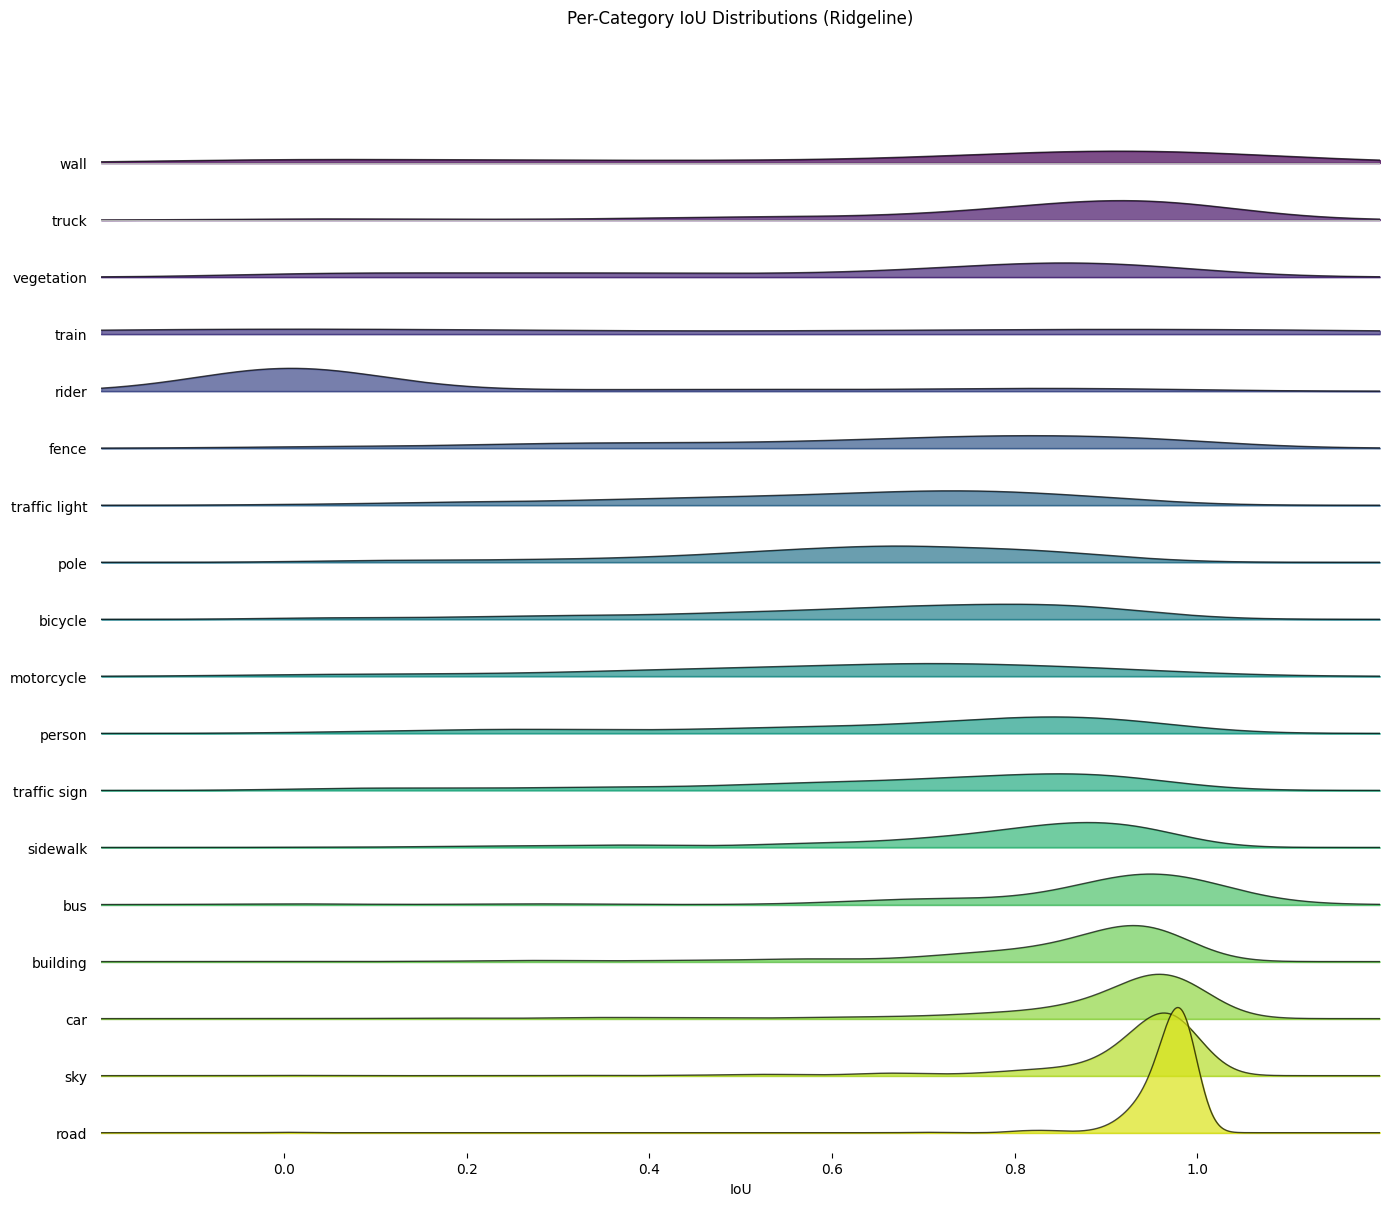

In [24]:
import joypy
import matplotlib.pyplot as plt

# Pivot long_df back to wide form for joypy
pivot_df = plot_df.pivot(columns='category', values='IoU')
norm_df = pivot_df.apply(lambda s: (s - s.min()) / (s.max() - s.min()))

plt.figure(figsize=(10, 12))
joypy.joyplot(
    data=norm_df,
    column=[x for x in sorted_classes if x != 'terrain'],
    labels=[x for x in sorted_classes if x != 'terrain'],
    range_style='own',
    grid="y",
    linewidth=1,
    legend=False,
    figsize=(14, 12),
    title="Distribution of Per-Image IoU by Class (NaNs removed correctly)",
    colormap=plt.cm.viridis,
    alpha=0.7,
    overlap=1.4,
)
# joypy.joyplot(
#     pivot_df,
#     column=sorted_classes,
#     labels=sorted_classes,
#     kind="kde",
#     range_style="own",
#     bw_method=0.3,     # ← try values 0.1–0.3 for smoothness
#     linewidth=1,
#     colormap=plt.cm.viridis,
#     overlap=1.4,
# )
plt.title("Per-Category IoU Distributions (Ridgeline)")
plt.xlabel("IoU")
plt.show()


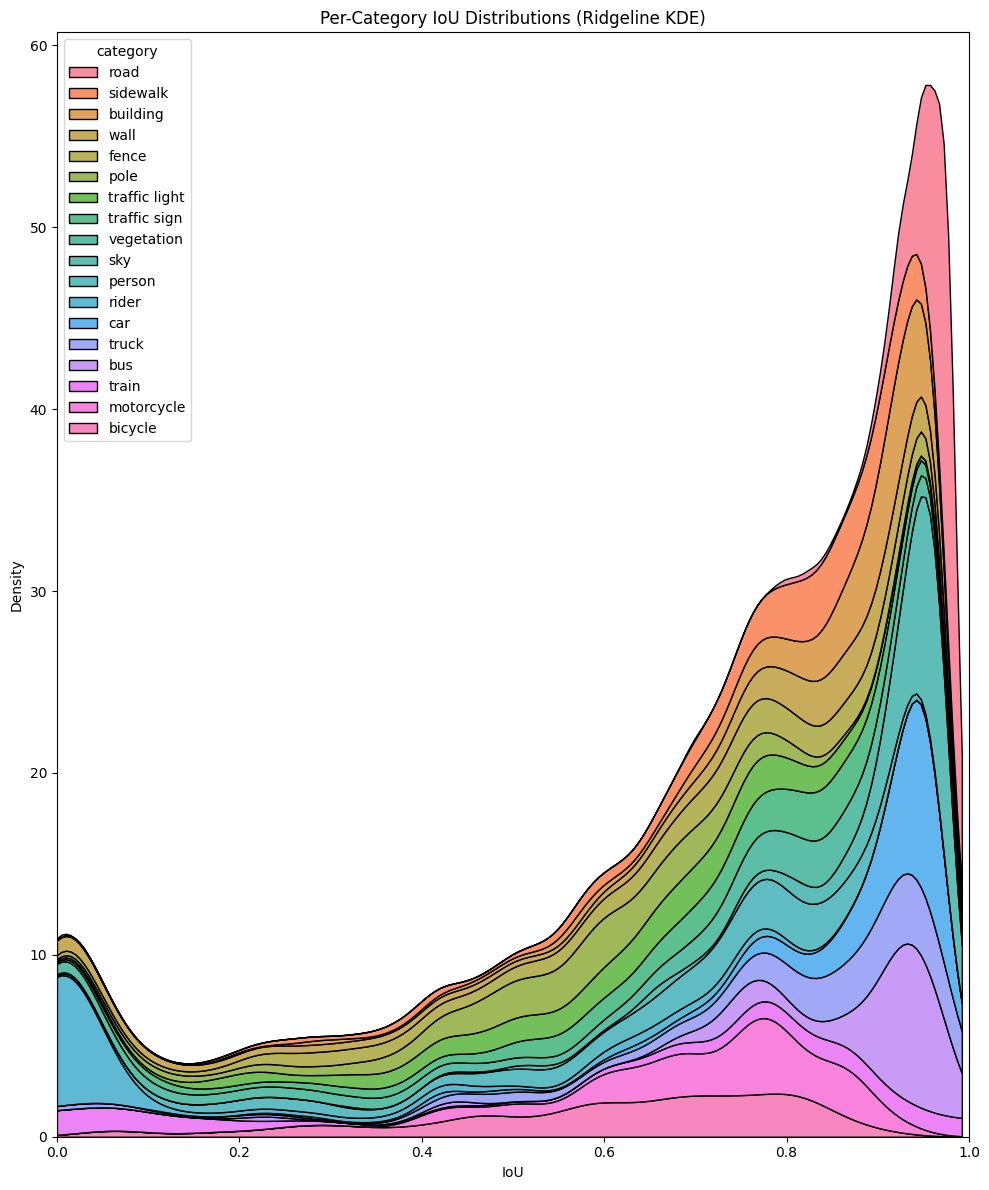

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 12))

sns.kdeplot(
    data=plot_df,
    x="IoU",
    hue="category",
    fill=True,
    alpha=0.8,
    linewidth=1,
    multiple="stack",
    common_norm=False,
    bw_adjust=0.5,
    cut=0
)

plt.xlim(0, 1)
plt.title("Per-Category IoU Distributions (Ridgeline KDE)")
plt.xlabel("IoU")
plt.tight_layout()
plt.show()


In [27]:
# Construct a filename based on the model class name
model_name = "SAM3-solo"
csv_filename = f"{model_name}_per_image_iou.csv"
save_path = CITYSCAPES_ROOT / "benchmark_results" / csv_filename

# Ensure directory exists
save_path.parent.mkdir(parents=True, exist_ok=True)

# Save
per_image_iou_df.to_csv(save_path, index=False)
print(f"Saved per-image IoU stats to: {save_path}")

Saved per-image IoU stats to: /content/drive/MyDrive/UCLA/Datasets/cityscapes/benchmark_results/SAM3-solo_per_image_iou.csv
